In [1]:
import pandas as pd
import numpy as np
import string
import csv   
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
import lightgbm as lgbm
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
        

In [2]:
class Visualizations:
    
    data = pd.DataFrame()
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    #Visualizations Constructor
    def __init__(self):
        print('Data Exploration')
        self.read_files()
        self.scatter_plot()
        self.correlation_matrix()
        self.heatmap()
        self.boxplot()
        
    #Reading Input Files
    def read_files(self):
        self.train = pd.read_csv('train1.csv', engine='python')
        self.test = pd.read_csv('test1.csv', engine='python')
        self.data = self.train
        
    #Scatter plot of various features
    def scatter_plot(self):
        print('Scatter Plot of various features against mean temperature')
        sns.set(color_codes=True)
        
        data = self.data
        plt.subplot(3,3,1) 
        sns.regplot(x=data['temp_mean'], y=data['pressure'], data=data);
        
        plt.subplot(3,3,2)
        sns.regplot(x=data['temp_mean'], y=data['humidity_mean'], data=data);
        
        plt.subplot(3,3,3)
        sns.regplot(x=data['temp_mean'], y=data['sunshine_duration'], data=data);
        
        plt.subplot(3,3,4)
        sns.regplot(x=data['temp_mean'], y=data['wind_speed_max_10m'], data=data);
        
        plt.subplot(3,3,5)
        sns.regplot(x=data['temp_mean'], y=data['day'], data=data);
        
        plt.subplot(3,3,6)
        sns.regplot(x=data['temp_mean'], y=data['total_cloudcover_mean'], data=data);
        
        plt.tight_layout()
        plt.show()
        
        
    #Correlation Matrix
    def correlation_matrix(self):
        
        print('Co relation matrix between various features and mean temperature')
        data = self.data
        new = data[['temp_mean', 'pressure', 'humidity_mean','snowfall_lr','total_cloudcover_mean','windgust_mean','sunshine_duration','shortwave_radiation']].copy() 
        corr = new.corr()
        fig, ax = plt.subplots(figsize=(10, 10))
        colormap = sns.diverging_palette(220, 10, as_cmap=True)
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
        plt.xticks(range(len(corr.columns)), corr.columns);
        plt.yticks(range(len(corr.columns)), corr.columns)
        plt.show()

        
    #Boxplot depicting range of various parameters
    def boxplot(self):
        
        print('Box plot diagrams to get proper range of various parameters. Helps in determining how to scale the feature.')
        data = self.data
        sns.set(style="whitegrid")
        ax = sns.boxplot(x=data["temp_mean"])
        plt.show()
        
        sns.set(style="whitegrid")
        ax = sns.boxplot(x=data["pressure"])
        plt.show()
        
        sns.set(style="whitegrid")
        ax = sns.boxplot(x=data["humidity_mean"])
        plt.show()
        
    
    #Heatmap temperature vs month for the year 2016
    def heatmap(self):
        
        print('Heatmap showing variation of temperature vs  month and day for the year 2016.')
        data = self.data
        x = data.loc[data['year'] == 2016]
        x=x.pivot("month", "day", "temp_mean")
        ax = sns.heatmap(x)
        ax.set_facecolor('xkcd:salmon')
        plt.show()
        
    #Returns train and test data
    def getData(self):
        return self.train, self.test

        

In [3]:
class FeatureEngineering:
    
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    #Constructor
    def __init__(self, train, test):
        print('Feature Engineering')
        self.train = train
        self.test = test
        self.train, self.test = self.data_cleaning(self.train, self.test)
        print('\nFeature Engineering')
        print('\tScaling pressure, humidity and other important paremeters appropriately.')
        self.train = self.added_features(self.train)
        self.test = self.added_features(self.test)
        
        
    #Remove unnecessary features
    def data_cleaning(self, train, test):

        print('Data cleaning')
        print('\tRemoving features that do not hold much significance.')
        print('\tcloud cover and timely parameters')
        
        train = train.drop(['year', 'month', 'day', 'hour', 'minute', 'temp_max', 'temp_min', 'total_cloudcover_max',
                           'total_cloudcover_min', 'high_cloudcover_max', 'high_cloudcover_min',
                            'medium_cloudcover_max', 'medium_cloudcover_min', 'low_cloudcover_max', 
                            'low_cloudcover_min'], axis=1)
        
        test = test.drop(['year', 'month', 'day', 'hour', 'minute', 'temp_max', 'temp_min', 'total_cloudcover_max',
                           'total_cloudcover_min', 'high_cloudcover_max', 'high_cloudcover_min',
                            'medium_cloudcover_max', 'medium_cloudcover_min', 'low_cloudcover_max', 
                            'low_cloudcover_min'], axis=1)
        
        return train, test
    
    #Returns final featured and cleaned train and test data
    def added_features(self, data):
        
        EPSILON = 0.0000001
        data['pressure_log'] = np.log(data.pressure + EPSILON)
        data['pressure_sqrt'] = np.sqrt(data.pressure)
        data['humidity_mean_log'] = np.log(data.humidity_mean + EPSILON)
        data['humidity_mean_sqrt'] = np.sqrt(data.humidity_mean)
        
        a = np.array([data['dew_point_max'], data['dew_point_min']])
        data['dew_point_mean'] = a.mean(axis=0)
        data = data.drop('dew_point_max', 1);
        data = data.drop('dew_point_min', 1);
        return data
        
    #Returns final featured and cleaned train and test data
    def getData(self):
        return self.train, self.test
    
    
    
    

In [4]:
class ModelComparisions:

    stack = pd.DataFrame()
    test_stack = pd.DataFrame()
    train = pd.DataFrame()
    val = pd.DataFrame()
    X = pd.DataFrame()
    Y = pd.DataFrame()
    val_X = pd.DataFrame()
    val_Y = pd.DataFrame()
    model_rmse = pd.DataFrame()
    linearModel = LinearRegression()
    randomModel = RandomForestRegressor()
    stackedModel = LinearRegression()
    
    #Model Comparisions Constructor
    def __init__(self, train):
        
        print('Model Comparisions')
        self.train, self.val = train_test_split(train, train_size=0.5, random_state=42)
        self.X = self.train.drop('temp_mean', 1)
        self.Y = self.train['temp_mean']
        
        self.val_X = self.val.drop('temp_mean', 1)
        self.val_Y = self.val['temp_mean']
        
    
    #Check Linear Regression RMSE
    def checkLinearRegression(self):
        
        model = LinearRegression()
        self.linearModel = model.fit(self.X, self.Y)
        
        val_Y = list(self.val_Y)
        p = list(model.predict(self.val_X))
        
        print('\tLinearRegression', self.print_rmse(val_Y, p))
        self.stack['linear_regression'] = p
        
        
    #Check RandomForest RMSE
    def checkRandomForest(self):
        
        model = RandomForestRegressor(
            n_estimators=1000,
            n_jobs=8,
            random_state=28,
            max_features=0.8
            )
        self.randomModel = model.fit(self.X,self.Y)
        
        val_Y = list(self.val_Y)
        p = list(model.predict(self.val_X))
        print('\tRandomForest', self.print_rmse(val_Y, p))
        self.stack['random_forest'] = p
        
        
    #Check Stacking on Linear Regression
    def stacking(self):
        
        X = self.stack
        Y = self.val['temp_mean']
        model = LinearRegression()
        self.stackedModel = model.fit(X, Y)
        
        
    #Display Model RMSE of all models
    def display_model_rmse(self):
        
        val_Y = list(self.val_Y)
        
        model = lgbm.sklearn.LGBMRegressor()
        model.fit(self.X,self.Y)
        p = list(model.predict(self.val_X))
        self.model_rmse['light_gbm'] = self.print_rmse(val_Y, p) 
        print('\tLGBMRegressor', self.print_rmse(val_Y, p))
        
       
        model = RandomForestRegressor(
            n_estimators=1000,
            n_jobs=8,
            random_state=28,
            max_features=0.8
            )
        model.fit(self.X, self.Y)        
        p = list(model.predict(self.val_X))
        self.model_rmse['random_forest'] = self.print_rmse(val_Y, p)
        print('\tRandomForestRegressor', self.print_rmse(val_Y, p))
        
        
        model = LinearRegression()
        model.fit(self.X, self.Y)
        p = list(model.predict(self.val_X))
        self.model_rmse['linear_regression'] = self.print_rmse(val_Y, p)
        print('\tLinearRegression', self.print_rmse(val_Y, p))
        
        
        model = SVR(C=1.0, epsilon=0.2)
        model.fit(self.X, self.Y)
        p = list(model.predict(self.val_X))
        self.model_rmse['svr'] = self.print_rmse(val_Y, p)
        print('\tSVR', self.print_rmse(val_Y, p))
       
    
    #Graphical comparision of RMSE values of different models
    def display_comparision_graph(self):
        x=["LGBMRegressor", "RandomForestRegressor", "LinearRegression"]
        y=[0.763696713583,0.807126268683,0.519368877902]
        ax = sns.barplot(x=x, y=y)
        plt.show()
    
    
    #Displays RMSE
    def print_rmse(self, test_Y, p):
        return np.sqrt(mean_squared_error(test_Y, p))


In [8]:
class ThePickler:
    
    stackTrain = pd.DataFrame()
    stackTest = pd.DataFrame()
    data = pd.DataFrame()
    test_X = pd.DataFrame()
    test_Y = pd.DataFrame()
    stkModel = ""
   
    #Pickler Constructor
    def __init__(self):
        fileName = "stackModel.pkl"
        self.stkModel = pickle.load(open(fileName, 'rb'))
        
    #Main underlying functionality of Pickle Class
    def trainer(self, test):
        
        self.data = test
        self.test_X = self.data.drop('temp_mean', 1)
        self.test_Y = self.data['temp_mean']
        self.stackTrain['linear'] = self.stkModel.linearModel.predict(self.test_X)
        self.stackTrain['random'] = self.stkModel.randomModel.predict(self.test_X)
        stacking = self.stkModel.stackedModel.predict(self.stackTrain)
        
        return stacking

In [6]:
class TestingPickle:
    
    #Testing the pickle file using it's constructor
    def __init__(self):
        
        feFileName = 'FeatureEngineering.pkl'
        test1 = pickle.load(open(feFileName, mode='rb'))

        linearModel = pickle.load(open("linearModel.pkl",'rb'))
        randomModel = pickle.load(open("randomModel.pkl",'rb'))
        stackedModel = pickle.load(open("stackModel.pkl",'rb'))


        test =  test1.drop('temp_mean', 1)
        tempDataFrame = pd.DataFrame()
        tempDataFrame['linearModel'] = linearModel.predict(test)
        tempDataFrame['randomModel'] = randomModel.predict(test)
        p = stackedModel.predict(tempDataFrame)

        print('\tStacking',np.sqrt(mean_squared_error(test1['temp_mean'], p)))

Data Exploration
Scatter Plot of various features against mean temperature


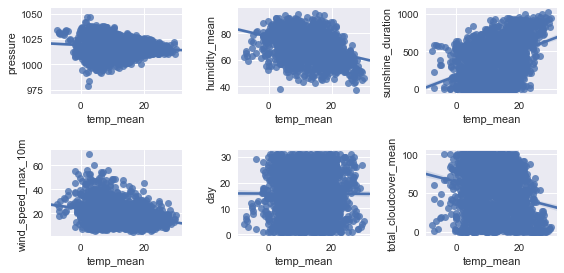

Co relation matrix between various features and mean temperature


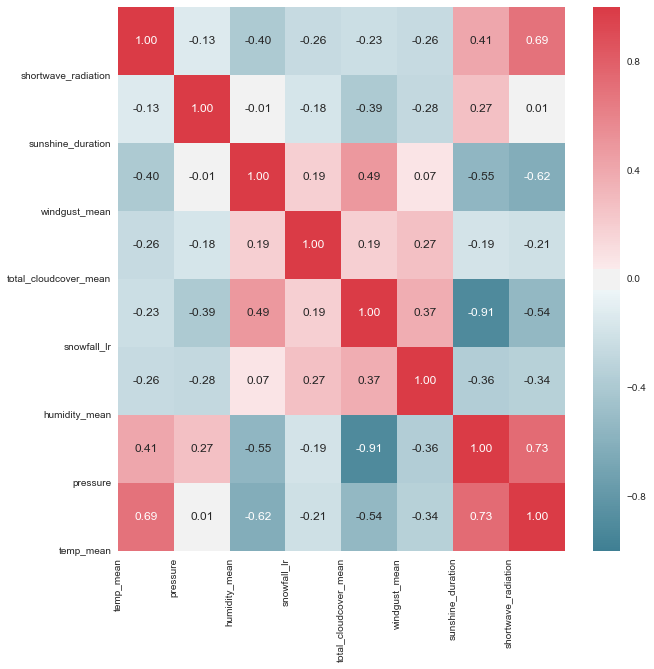

Heatmap showing variation of temperature vs  month and day for the year 2016.


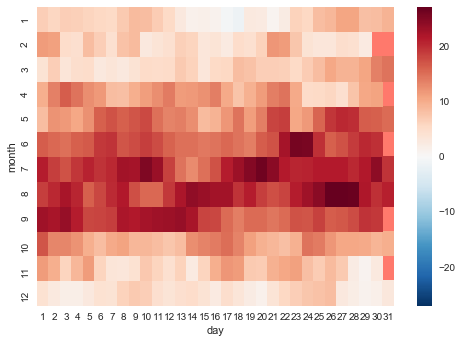

Box plot diagrams to get proper range of various parameters. Helps in determining how to scale the feature.


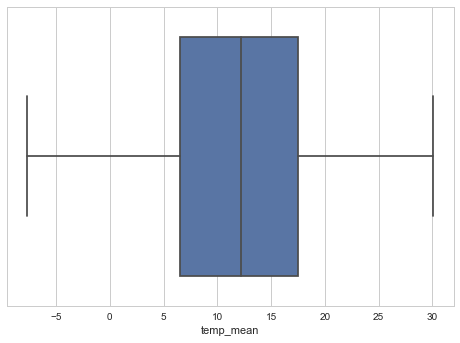

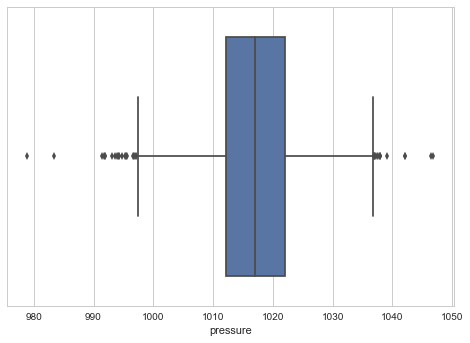

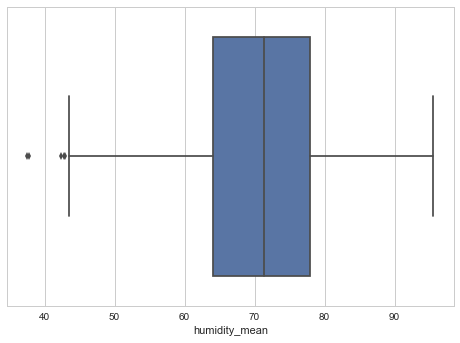

Feature Engineering
Data cleaning
	Removing features that do not hold much significance.
	cloud cover and timely parameters

Feature Engineering
	Scaling pressure, humidity and other important paremeters appropriately.


Model Comparisions
	LGBMRegressor 0.763696713583
	RandomForestRegressor 0.807126268683
	LinearRegression 0.519368877902
	SVR 6.96118750353


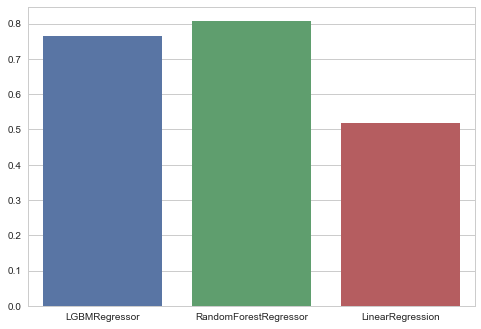


Implementing Stacking with Linear Regression as secondary model
	LinearRegression 0.519368877902
	RandomForest 0.807126268683


FileNotFoundError: [Errno 2] No such file or directory: 'stackTrainer.pkl'

In [7]:
class StartClass:
    
    #Initial start point main function
    if __name__ == '__main__':
        
        #Visualizations
        visual_obj = Visualizations()
        train, test = visual_obj.getData()
        
        #Feature Engineering and Data Cleaning
        obj = FeatureEngineering(train, test)
        train, test = obj.getData()
        feFileName = 'FeatureEngineering.pkl'
        pickle.dump(test, open(feFileName,'wb'))
        print('\n')
        
        #Model Comparisions
        model_object = ModelComparisions(train)
        model_object.display_model_rmse()
        model_object.display_comparision_graph()
        print('\nImplementing Stacking with Linear Regression as secondary model')
        model_object.checkLinearRegression()
        model_object.checkRandomForest()
        model_object.stacking()
        pickle.dump(model_object.linearModel, open("linearModel.pkl", 'wb'))
        pickle.dump(model_object.randomModel, open("randomModel.pkl", 'wb'))
        pickle.dump(model_object.stackedModel, open("stackModel.pkl", 'wb'))
        
        #Testing the various pickle models and stacking them together to get the final answer
        finishModel = ThePickler()
        finalPickle = "finalPickle.pkl"
        pickle.dump(finishModel, open(finalPickle,'wb'))
        works = pickle.load(open(finalPickle,'rb'))
        
        testing_pickle = TestingPickle()
        